# **Multi-Class Classification** - [`spirals data` creation function from **CS231n**]

Shape of X, y: ((1500, 2), (1500,))


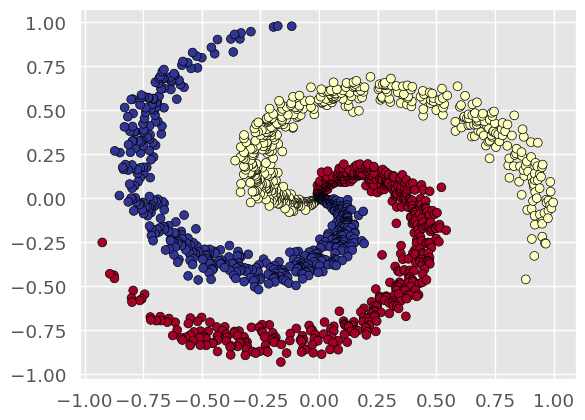

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Parameters for dataset creation
N = 500  # Defines the number of points per class.
D = 2     # Defines the dimensionality of the data (2D in this case).
K = 3     # Defines the number of classes.

# Initialize data matrix and class labels
X = np.zeros((N*K, D))            # Initializes a `Data Matrix` X with zeros, where each row represents a single example and has a dimension of D.
y = np.zeros(N*K, dtype='uint8')  # Initializes an array y to store class labels, with a length of N*K (number of points per class times number of classes),
                                  # and sets the data type to unsigned 8-bit integers.

# Generate spiral dataset
for j in range(K):
    ix = range(N * j, N * (j + 1)) # Computes the indices corresponding to the current class in the data matrix.
    r = np.linspace(0.0, 1, N)     # Generates N equally spaced points between 0.0 and 1, representing the radius.
    t = np.linspace(j * 4, (j + 1) * 4, N) + (np.random.randn(N)*0.2)  # Generates N equally spaced points between j*4 and (j+1)*4,
                                                                       # representing `theta (angle)`, and adds some random noise to it.
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)] # Calculates the x and y coordinates based on the polar coordinates (r and theta)
    y[ix] = j                                   # Sets the class label for the current class.


print(f"Shape of X, y: {X.shape, y.shape}")

# Visualize the data
plt.style.use("ggplot")
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, edgecolors="black")
plt.show()

>**NOTE:** When using PyTorch's CrossEntropyLoss, the target labels should be converted to `torch.LongTensor` because this loss function expects integer class indices to compute the negative log-likelihood loss accurately.

In [23]:
import torch
from sklearn.model_selection import train_test_split

# Convert data to Tensor
X = torch.from_numpy(X).type(torch.float32)     # Convert features to float32
y = torch.from_numpy(y).type(torch.LongTensor)  # Convert target labels to LongTensor for CrossEntropyLoss

print(X.dtype, y.dtype)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print lengths and shapes of train and test sets
print("Train set size:", len(X_train), len(y_train))
print("Test set size:", len(X_test), len(y_test))
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Print an example data point from the train set
print("Example data point from train set:", X_train[0], y_train[0])

torch.float32 torch.int64
Train set size: 1200 1200
Test set size: 300 300
Train set shape: torch.Size([1200, 2]) torch.Size([1200])
Test set shape: torch.Size([300, 2]) torch.Size([300])
Example data point from train set: tensor([ 0.3699, -0.6703]) tensor(0)


In [24]:
import torch
from torch import nn

# Create the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Build a multi-class classification model
class SpiralModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=16)
        self.layer2 = nn.Linear(in_features=16, out_features=16)
        self.layer3 = nn.Linear(in_features=16, out_features=3)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model = SpiralModel().to(device)

print("Model's: ", next(model.parameters()))
print("Model's device: ", next(model.parameters()).device)
print(model)
print(model.state_dict().keys())

Model's:  Parameter containing:
tensor([[-0.4054, -0.5290],
        [ 0.2628, -0.0680],
        [ 0.3121, -0.2919],
        [-0.5276, -0.4346],
        [ 0.0798,  0.3690],
        [-0.1921, -0.2967],
        [ 0.4265, -0.1841],
        [ 0.2174,  0.1417],
        [ 0.6780,  0.5050],
        [-0.1613, -0.6149],
        [ 0.2045, -0.1925],
        [ 0.3060, -0.6507],
        [ 0.3491,  0.4106],
        [ 0.5636,  0.0867],
        [-0.5355,  0.2422],
        [ 0.6143, -0.2732]], requires_grad=True)
Model's device:  cpu
SpiralModel(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
)
odict_keys(['layer1.weight', 'layer1.bias', 'layer2.weight', 'layer2.bias', 'layer3.weight', 'layer3.bias'])


In [25]:
# Put the data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

torch.float32 torch.float32 torch.int64 torch.int64


In [26]:
# Let's calculate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics

In [27]:
# Setup the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

# setup the accuracy
import torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [28]:
# Print untraind model output
y_logits = model(X_train)
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = torch.argmax(y_pred_probs, dim=1)

print(y_preds[:5], y_test[:5])
print(acc_fn(preds=y_preds, target=y_train.int()))

tensor([2, 2, 2, 2, 2]) tensor([2, 2, 0, 0, 0])
tensor(0.3200)


Epoch: 0 | Loss: 1.10 Acc: 0.32 | Test loss: 1.10 Test acc: 0.42
Epoch: 100 | Loss: 0.16 Acc: 0.96 | Test loss: 0.15 Test acc: 0.96
Epoch: 200 | Loss: 0.04 Acc: 1.00 | Test loss: 0.03 Test acc: 0.99
Epoch: 300 | Loss: 0.02 Acc: 1.00 | Test loss: 0.02 Test acc: 0.99
Epoch: 400 | Loss: 0.01 Acc: 1.00 | Test loss: 0.02 Test acc: 0.99
Epoch: 500 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00
Epoch: 600 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 Test acc: 0.99
Epoch: 700 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 Test acc: 0.99
Epoch: 800 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00
Epoch: 900 | Loss: 0.01 Acc: 1.00 | Test loss: 0.01 Test acc: 1.00




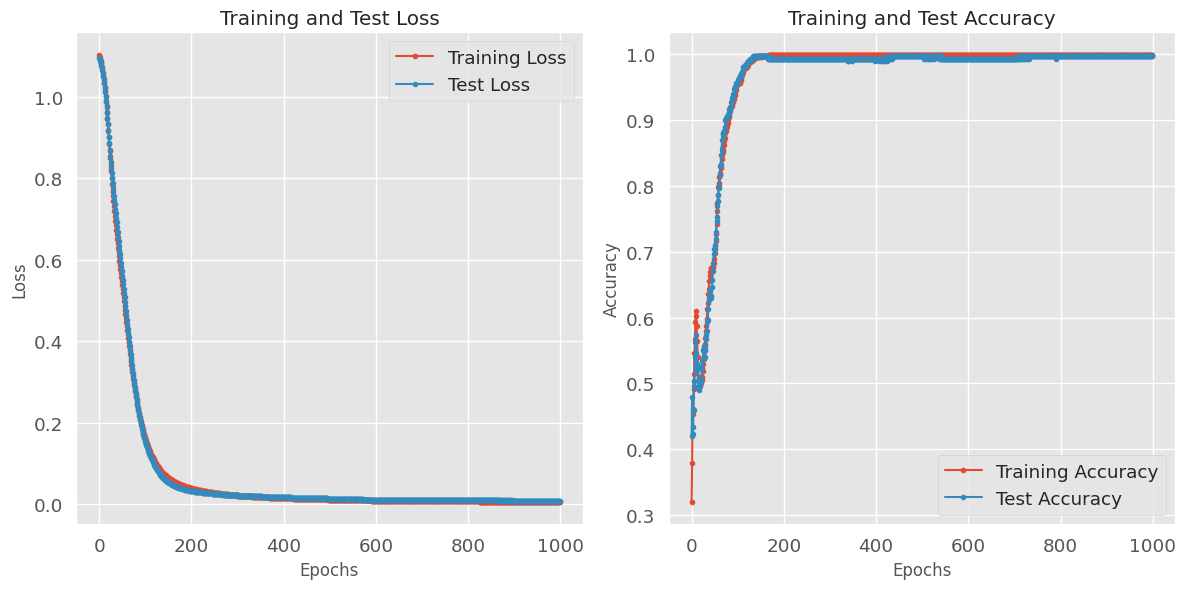

In [29]:
# Build a training loop for the model
epochs = 1000

# Define lists to store metrics for plotting
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Loop over data
for epoch in range(epochs):
    ## Training
    model.train()

    # 1. forward pass
    y_logits = model(X_train)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_preds = torch.argmax(y_pred_probs, dim=1)

    # 2. calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_preds, y_train)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backwards
    loss.backward()

    # 5. optimizer step step step
    optimizer.step()

    # Appending train loss and accuracy to the list
    train_losses.append(loss.item())
    train_accuracies.append(acc)

    ## Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Caculate loss and acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test)

        # Appending test loss and  test accuracy to the list
        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")




print("\n")

# Plotting training and testing metrics
plt.figure(figsize=(12, 6))
plt.style.use("ggplot")

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label="Training Loss", marker='.')
plt.plot(range(epochs), test_losses, label="Test Loss", marker='.')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label="Training Accuracy", marker=".")
plt.plot(range(epochs), test_accuracies, label="Test Accuracy", marker=".")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mohd-faizy/PyTorch-Essentials/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

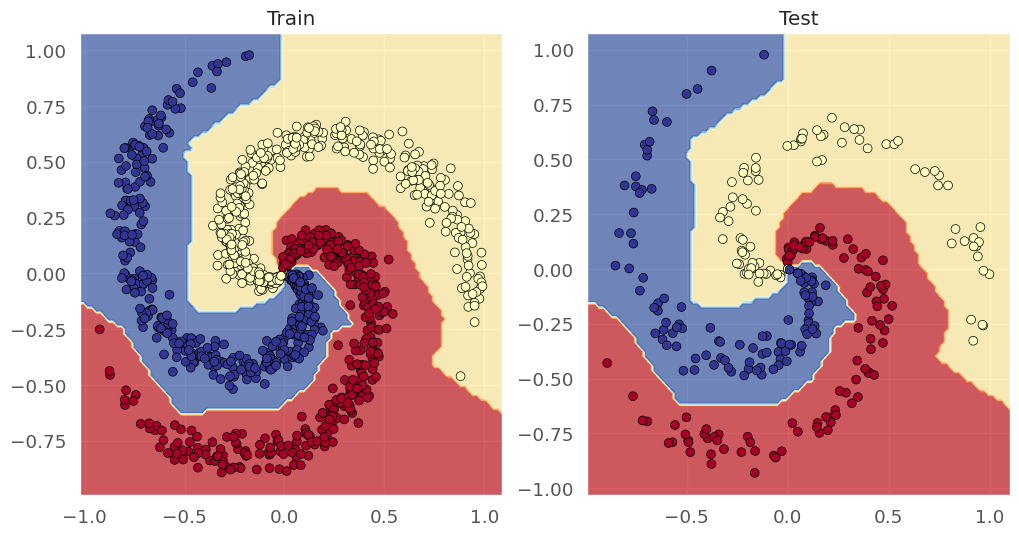

In [31]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

torch.float32 torch.int64
Epoch: 0 | Loss: 1.10 | Acc: 0.35 | Test loss: 1.09 Test acc: 0.35 | Precision: 0.116 | Recall: 0.333 | F1-score: 0.172
Epoch: 100 | Loss: 0.22 | Acc: 0.95 | Test loss: 0.21 Test acc: 0.95 | Precision: 0.949 | Recall: 0.950 | F1-score: 0.949
Epoch: 200 | Loss: 0.04 | Acc: 1.00 | Test loss: 0.03 Test acc: 1.00 | Precision: 0.997 | Recall: 0.996 | F1-score: 0.997
Epoch: 300 | Loss: 0.02 | Acc: 1.00 | Test loss: 0.02 Test acc: 1.00 | Precision: 0.996 | Recall: 0.997 | F1-score: 0.997
Epoch: 400 | Loss: 0.01 | Acc: 1.00 | Test loss: 0.02 Test acc: 1.00 | Precision: 0.996 | Recall: 0.997 | F1-score: 0.997
Epoch: 500 | Loss: 0.01 | Acc: 0.99 | Test loss: 0.02 Test acc: 0.99 | Precision: 0.993 | Recall: 0.993 | F1-score: 0.993
Epoch: 600 | Loss: 0.01 | Acc: 0.99 | Test loss: 0.02 Test acc: 0.99 | Precision: 0.993 | Recall: 0.993 | F1-score: 0.993
Epoch: 700 | Loss: 0.01 | Acc: 0.99 | Test loss: 0.02 Test acc: 0.99 | Precision: 0.993 | Recall: 0.993 | F1-score: 0.993


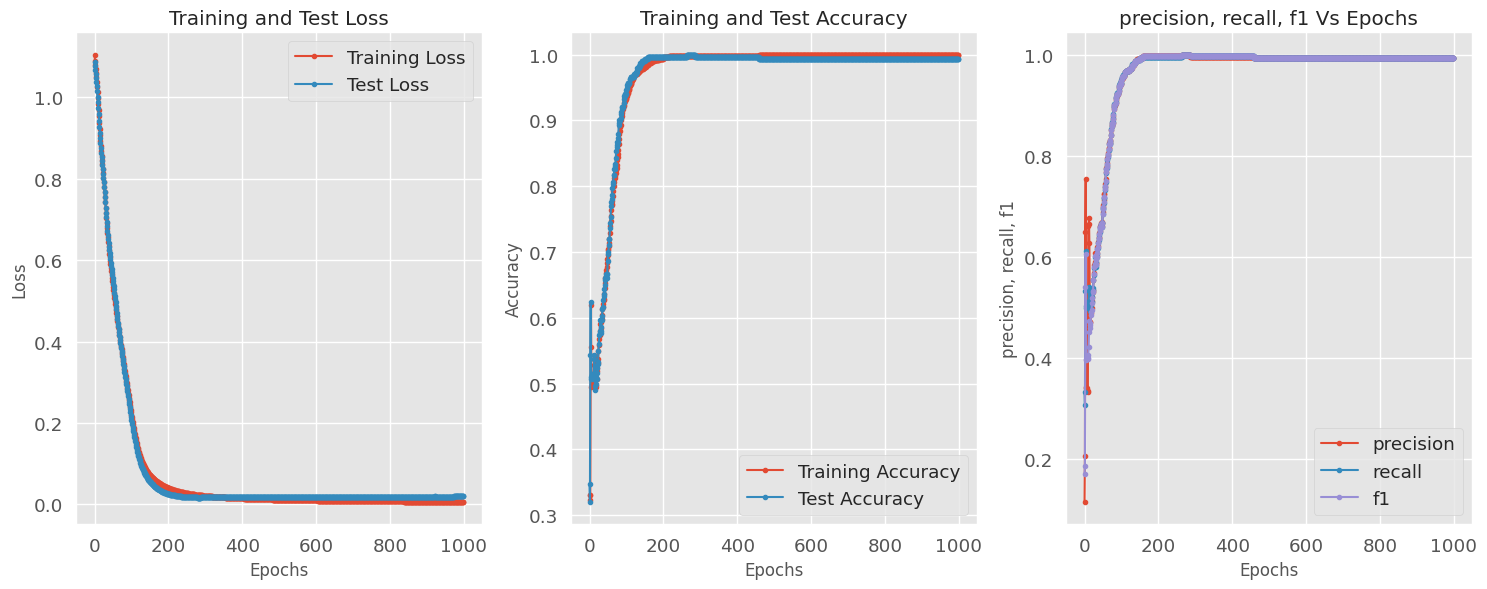

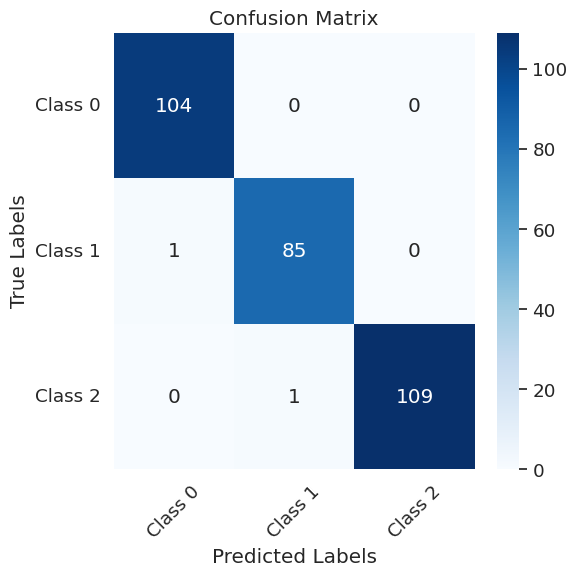

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Parameters for dataset creation
N = 500  # Defines the number of points per class.
D = 2     # Defines the dimensionality of the data (2D in this case).
K = 3     # Defines the number of classes.

# Initialize data matrix and class labels
X = np.zeros((N*K, D))            # Initializes a `Data Matrix` X with zeros, where each row represents a single example and has a dimension of D.
y = np.zeros(N*K, dtype='uint8')  # Initializes an array y to store class labels, with a length of N*K (number of points per class times number of classes),
                                  # and sets the data type to unsigned 8-bit integers.

# Generate spiral dataset
for j in range(K):
    ix = range(N * j, N * (j + 1)) # Computes the indices corresponding to the current class in the data matrix.
    r = np.linspace(0.0, 1, N)     # Generates N equally spaced points between 0.0 and 1, representing the radius.
    t = np.linspace(j * 4, (j + 1) * 4, N) + (np.random.randn(N)*0.2)  # Generates N equally spaced points between j*4 and (j+1)*4,
                                                                       # representing `theta (angle)`, and adds some random noise to it.
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)] # Calculates the x and y coordinates based on the polar coordinates (r and theta)
    y[ix] = j                                   # Sets the class label for the current class.

# Convert data to Tensor
X = torch.from_numpy(X).type(torch.float32)     # Convert features to float32
y = torch.from_numpy(y).type(torch.LongTensor)  # Convert target labels to LongTensor for CrossEntropyLoss

print(X.dtype, y.dtype)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Build a multi-class classification model
class SpiralModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=16)
        self.layer2 = nn.Linear(in_features=16, out_features=16)
        self.layer3 = nn.Linear(in_features=16, out_features=3)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model = SpiralModel().to(device)


# Function to evaluate classification metrics
def evaluate_metrics(preds, target, num_classes, device):
    acc_fn = Accuracy(task="multiclass", num_classes=num_classes)
    precision_fn = Precision(num_classes=num_classes, average='macro', task="multiclass")
    recall_fn = Recall(num_classes=num_classes, average='macro', task="multiclass")
    f1_fn = F1Score(num_classes=num_classes, average='macro', task="multiclass")
    confusion_matrix_fn = ConfusionMatrix(num_classes=num_classes, task="multiclass")

    acc = acc_fn(preds, target)
    precision = precision_fn(preds, target)
    recall = recall_fn(preds, target)
    f1 = f1_fn(preds, target)
    confusion_matrix_result = confusion_matrix_fn(preds, target)

    return acc, precision, recall, f1, confusion_matrix_result



# Setup the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

# setup the accuracy
import torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn


# Assuming you have your model (model), training data (X_train), and testing data (X_test)
# Build a training loop for the model
epochs = 1000

# Define lists to store metrics for plotting
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
precision_list, recall_list, f1_list = [], [], []  # Renamed variables to avoid conflict

# Looping over data
for epoch in range(epochs):
    ### -----------------------Training-----------------------
    model.train()

    # 1. forward pass
    y_logits = model(X_train)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_preds = torch.argmax(y_pred_probs, dim=1)

    # 2. calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_preds, y_train)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backwards
    loss.backward()

    # 5. optimizer step step step
    optimizer.step()

    # Append Train metrics to lists for plotting
    train_losses.append(loss.item())
    train_accuracies.append(acc)


    ### -----------------------Testing-----------------------
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Calculate loss and acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test)

        # Append Test Metrics to lists for plotting
        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc)

        # Evaluate metrics
        acc, prec, rec, f1, confusion_matrix_result = evaluate_metrics(preds=test_pred, target=y_test, num_classes=3, device=device)

        # Appending the Evaluation metrics
        precision_list.append(prec.item())
        recall_list.append(rec.item())
        f1_list.append(f1.item())


    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} | Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1-score: {f1:.3f}")


print("\n")

### -----------------------Ploting the Metrics-----------------------
# Plotting training and testing metrics
plt.figure(figsize=(15, 6))  # Adjust the figure size to accommodate three subplots
# plt.style.use("ggplot")

plt.subplot(1, 3, 1)
plt.plot(range(epochs), train_losses, label="Training Loss", marker='.')
plt.plot(range(epochs), test_losses, label="Test Loss", marker='.')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(epochs), train_accuracies, label="Training Accuracy", marker=".")
plt.plot(range(epochs), test_accuracies, label="Test Accuracy", marker=".")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(epochs), precision_list, label="precision", marker=".")
plt.plot(range(epochs), recall_list, label="recall", marker=".")
plt.plot(range(epochs), f1_list, label="f1", marker=".")
plt.xlabel("Epochs")
plt.ylabel("precision, recall, f1")
plt.title("precision, recall, f1 Vs Epochs")
plt.legend()

plt.tight_layout()
plt.show()

print("\n")
### -----------------------Ploting the Confusion Metrics-----------------------
# Assuming confusion_matrix_result is a torch.Tensor representing the confusion matrix
confusion_matrix_np = confusion_matrix_result.to(device)

# Define class labels (replace with your actual class labels if different)
class_labels = ["Class 0", "Class 1", "Class 2"]

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.set(font_scale=1.2)  # Adjust font size if needed
sns.heatmap(confusion_matrix_np, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(np.arange(len(class_labels)) + 0.5, rotation=45)
plt.yticks(np.arange(len(class_labels)) + 0.5, rotation=0)
plt.tight_layout()
plt.show()

In [33]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mohd-faizy/PyTorch-Essentials/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


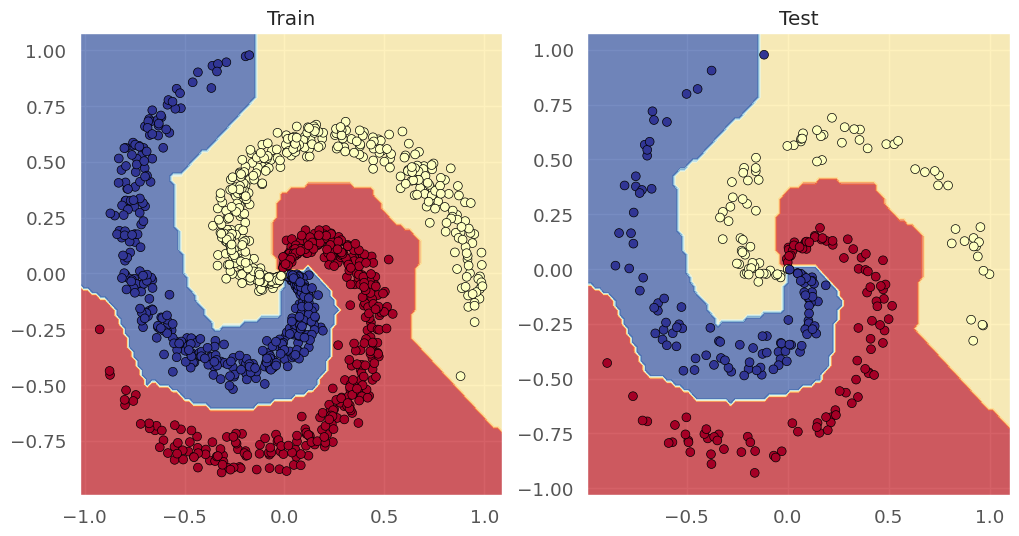

In [34]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)